# Autogen custom agents showcasing of a structered task planning/decomposition approach

Autogen agents do not readily generate structured output. In this notebook, we define custom agents that can generate strcutered outputs.

The models would be OpenAI or function calling open-source LLMs compatible with OpenAI. 

Structured output declarations are based on the pydantic class of Python, which enables validation of the format.


"""

In [1]:
%pip install -qqq rich
%pip install -qqq instructor
%pip install -qqq graphviz

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from rich import print as print
from rich.pretty import Pretty
from rich.syntax import Syntax
import asyncio
from collections.abc import Generator
from openai import OpenAI
from pydantic import Field, BaseModel
import instructor
import os
import graphviz

os.environ["OPENAI_API_KEY"] = "YOUR KEY HERE"

model="gpt-4-0613"
# model="gpt-4-0314"
# model="gpt-4o"
# model='gpt-4o-mini'

client = instructor.from_openai(OpenAI())


# model="llama3.1"
# model="gorilla-openfunctions-v2-q6_K.gguf"

# # enables `response_model` in create call
# client = instructor.from_openai(
#     OpenAI(
#         base_url="http://52.56.167.144:11434/v1",
#         api_key="ollama",  # required, but unused
#     ),
#     mode=instructor.Mode.JSON,
# )




In [3]:
#helper functions for visualisation
import json

def wrap_text(text, width=30):
    # Split the text into multiple lines, each not exceeding the specified width
    return "\\n".join(text[i:i + width] for i in range(0, len(text), width))

def save_dot_from_json(json_input, filename='task_graph.dot'):
    # Parse the JSON
    data = json.loads(json_input)

    # Start building the Graphviz DOT script with a more spacious layout
    dot_script = [
        'digraph TaskGraph {',
        '    node [shape=box];',
        '    rankdir=LR;',  # Top-to-Bottom layout; for Left-to-Right, use LR
        '    size="10,10";'  # Increase size if needed
    ]

    # Define tasks with wrapped text labels
    tasks = data['task_graph']
    for task in tasks:
        wrapped_label = wrap_text(f'Task {task["id"]}: {task["task"]}')
        dot_script.append(f'    {task["id"]} [label="{wrapped_label}"];')

    # Define edges based on subtasks (direction changed)
    for task in tasks:
        for subtask_id in task['subtasks']:
            dot_script.append(f'    {subtask_id} -> {task["id"]};')

    # Close the Graphviz script
    dot_script.append('}')

    # Save the DOT script to a file
    with open(filename, 'w') as file:
        file.write('\n'.join(dot_script))

    print(f"DOT file saved as '{filename}'.")


def display_graphviz(file):
    # Load the dot file
    with open(file, 'r') as file:
        dot_graph = file.read()
    # Render the graph
    graph = graphviz.Source(dot_graph)
    return graph

def display_graphviz_viewer(file):
    # Load the dot file
    with open(file, 'r') as file:
        dot_graph = file.read()
    # Render the graph
    graph = graphviz.Source(dot_graph)
    graph.render(view=True)  # This will open the graph in a viewer


In [4]:
class Task(BaseModel):
    """
    Class representing a single task in a task plan.
    """

    id: int = Field(..., description="Unique id of the task")
    task: str = Field(
        ...,
        description="""Contains the task in text form. If there are multiple tasks,
        this task can only be executed when all dependant subtasks have been answered.""",
    )
    subtasks: list[int] = Field(
        default_factory=list,
        description="""List of the IDs of subtasks that need to be answered before
        we can answer the main question. Use a subtask when anything may be unknown
        and we need to ask multiple questions to get the answer.
        Dependencies must only be other tasks.""",
    )


class TaskPlan(BaseModel):
    """
    Container class representing a tree of tasks and subtasks.
    Make sure every task is in the tree, and every task is done only once.
    """

    task_graph: list[Task] = Field(
        ...,
        description="List of tasks and subtasks that need to be done to complete the main task. Consists of the main task and its dependencies.",
    )

## supports building recursive generic models
Task.model_rebuild()
TaskPlan.model_rebuild()

In [5]:
task4 = """

An example of source and target data structures are below:
source model example in json format:
    {
        "volume":177.0730798,
        "area":434.4258052,
        "length":0.0,
        "VolumeUnit":"m3",
        "Category":"CV-CV-Abutment-G-P",
        "ss_epd_id":"9cf0bb8930ab4d3a9e8082b475796fae",
        "ss_category_name":"ReadyMix",
        "Embodied_Carbon":54553.4986645559
    }

target model example translated from the example of source data model in json format:
    {
        "Name_notes":"CV-CV-Abutment-G-P",
        "Asset_Code":"9cf0bb8930ab4d3a9e8082b475796fae",
        "Quantity":177.0730798,
        "Unit":"m3",
        "Total":54553.4986645559,
        "Concrete":54553.4986645559
    }

another example:
source model example in json format:
source data model:
    {
        "volume":1.42005247,
        "area":74.7313579,
        "length":0.0,
        "VolumeUnit":"m3",
        "Category":"CV-CV-Barrier-G-P",
        "QTY":110,
        "ss_epd_id":"5e99ea4bf1124b66a0899c4e072550f4",
        "ss_category_name":"Steel",
        "Embodied_Carbon":6780.3888439634
    }
target model example translated from the example of source data model in json format:
    {
        "Name_notes":"CV-CV-Barrier-G-P",
        "Asset_Code":"5e99ea4bf1124b66a0899c4e072550f4",
        "Quantity":1.42005247,
        "Unit":"m3",
        "Total":6780.3888439634,
        "Steel":6780.3888439634,
    }


Write out translation logic to translate from  source data model to target data model using the tools that are given to you.
be careful with complex conditions like 
- mapping value of a source field to name of a target field
- mapping value of a source field to value of target field if the target field is created by mapping from a value of an another source field.
- mapping a source field name to multiple target field names
- Splitting a source field name into more than one target field names
- Splitting a source field value into more than one target field value

make sure target model values of target fields are populated accordingly.

this is the entry:
    {
        "volume":1.42005247,
        "area":74.7313579,
        "length":0.0,
        "VolumeUnit":"m3",
        "Category":"CV-CV-Barrier-G-P",
        "QTY":110,
        "ss_epd_id":"5e99ea4bf1124b66a0899c4e072550f4",
        "ss_category_name":"Steel",
        "Embodied_Carbon":6780.3888439634
    }
"""






In [6]:
from autogen import AssistantAgent, UserProxyAgent, config_list_from_json
from pydantic import BaseModel, Field, ValidationError
from typing import List, Optional, Union
from types import SimpleNamespace
import instructor
from openai import OpenAI
import litellm
from litellm import completion
import os
from dotenv import load_dotenv

flaml.automl is not available. Please install flaml[automl] to enable AutoML functionalities.


In [7]:
class CustomLLMClient:
    def __init__(self, config, **kwargs):
        print(f"CustomLLMClient config: {config}")

    def create(self, params):
        os.environ["OPENAI_API_KEY"] = "YOUR KEY HERE"
        client = instructor.from_openai(OpenAI())
        response = client.chat.completions.create(
            model="gpt-4-0613",
            messages=params["messages"],
            response_model=TaskPlan, 
            temperature=0,
        )

        autogen_response = SimpleNamespace()
        autogen_response.choices = []
        autogen_response.model = "custom_llm_planner"  

        choice = SimpleNamespace()
        choice.message = SimpleNamespace()
        choice.message.content = response.model_dump_json()
        choice.message.function_call = None
        autogen_response.choices.append(choice)
        return autogen_response

    def message_retrieval(self, response):
        choices = response.choices
        return [choice.message.content for choice in choices]

    def cost(self, response) -> float:
        response.cost = 0 
        return 0

    @staticmethod
    def get_usage(response):
        return {}

In [8]:
config_list=[
    {
        "model": "custom_llm_planner",
        "model_client_cls": "CustomLLMClient",
    }
]

In [9]:
user_proxy = UserProxyAgent("user_proxy", code_execution_config=False)
assistant = AssistantAgent(
    name="assistant",
    system_message="You are a world class task planning algorithm capable of breaking apart tasks into dependant subtasks, such that the answers can be used to enable the system completing the main task. Do not complete the user task, simply provide a correct compute graph with good specific tasks to ask and relevant subtasks. Before completing the list of tasks, think step by step to get a better understanding the problem.",
    llm_config={
        "config_list": config_list,  
        "cache": None, 
        "cache_seed": None
    },
)


[autogen.oai.client: 11-01 10:42:03] {509} INFO - Detected custom model client in config: CustomLLMClient, model client can not be used until register_model_client is called.


In [10]:
assistant.register_model_client(model_client_cls=CustomLLMClient)

CustomLLMClient config: {'model': 'custom_llm_planner', 'model_client_cls': 'CustomLLMClient'}

In [11]:
user_proxy.initiate_chat(
    assistant,
    message=task4,
)

assistant_response = assistant.last_message()["content"]


user_proxy (to assistant):



An example of source and target data structures are below:
source model example in json format:
    {
        "volume":177.0730798,
        "area":434.4258052,
        "length":0.0,
        "VolumeUnit":"m3",
        "Category":"CV-CV-Abutment-G-P",
        "ss_epd_id":"9cf0bb8930ab4d3a9e8082b475796fae",
        "ss_category_name":"ReadyMix",
        "Embodied_Carbon":54553.4986645559
    }

target model example translated from the example of source data model in json format:
    {
        "Name_notes":"CV-CV-Abutment-G-P",
        "Asset_Code":"9cf0bb8930ab4d3a9e8082b475796fae",
        "Quantity":177.0730798,
        "Unit":"m3",
        "Total":54553.4986645559,
        "Concrete":54553.4986645559
    }

another example:
source model example in json format:
source data model:
    {
        "volume":1.42005247,
        "area":74.7313579,
        "length":0.0,
        "VolumeUnit":"m3",
        "Category":"CV-CV-Barrier-G-P",
        "QTY":110,
        "s

Replying as user_proxy. Provide feedback to assistant. Press enter to skip and use auto-reply, or type 'exit' to end the conversation:  exit


TaskPlan(
    task_graph=[
        Task(id=1, task='Extract values from source data model', subtasks=[2, 3, 4, 5, 6, 7, 8, 9]),
        Task(id=2, task="Extract 'volume' value", subtasks=[]),
        Task(id=3, task="Extract 'VolumeUnit' value", subtasks=[]),
        Task(id=4, task="Extract 'Category' value", subtasks=[]),
        Task(id=5, task="Extract 'ss_epd_id' value", subtasks=[]),
        Task(id=6, task="Extract 'ss_category_name' value", subtasks=[]),
        Task(id=7, task="Extract 'Embodied_Carbon' value", subtasks=[]),
        Task(id=8, task="Check if 'QTY' field exists and extract its value", subtasks=[]),
        Task(id=9, task="Check if 'area' and 'length' fields exist and extract their values", subtasks=[]),
        Task(id=10, task='Create target data model', subtasks=[11, 12, 13, 14, 15, 16]),
        Task(id=11, task="Map 'Category' value to 'Name_notes' field in target model", subtasks=[]),
        Task(id=12, task="Map 'ss_epd_id' value to 'Asset_Code' field in target model", subtasks=[]),
        Task(id=13, task="Map 'volume' value to 'Quantity' field in target model", subtasks=[]),
        Task(id=14, task="Map 'VolumeUnit' value to 'Unit' field in target model", subtasks=[]),
        Task(id=15, task="Map 'Embodied_Carbon' value to 'Total' field in target model", subtasks=[]),
        Task(
            id=16,
            task="Map 'ss_category_name' value to a new field in target model with the same name and assign 
'Embodied_Carbon' value to it",
            subtasks=[]
        )
    ]
)

In [13]:

try:
    plan = TaskPlan.model_validate_json(assistant_response)
    print(plan)
except ValidationError as e:
    print(e)

TaskPlan(
    task_graph=[
        Task(id=1, task='Extract values from source data model', subtasks=[2, 3, 4, 5, 6, 7, 8, 9]),
        Task(id=2, task="Extract 'volume' value", subtasks=[]),
        Task(id=3, task="Extract 'VolumeUnit' value", subtasks=[]),
        Task(id=4, task="Extract 'Category' value", subtasks=[]),
        Task(id=5, task="Extract 'ss_epd_id' value", subtasks=[]),
        Task(id=6, task="Extract 'ss_category_name' value", subtasks=[]),
        Task(id=7, task="Extract 'Embodied_Carbon' value", subtasks=[]),
        Task(id=8, task="Check if 'QTY' field exists and extract its value", subtasks=[]),
        Task(id=9, task="Check if 'area' and 'length' fields exist and extract their values", subtasks=[]),
        Task(id=10, task='Create target data model', subtasks=[11, 12, 13, 14, 15, 16]),
        Task(id=11, task="Map 'Category' value to 'Name_notes' field in target model", subtasks=[]),
        Task(id=12, task="Map 'ss_epd_id' value to 'Asset_Code' field in target model", subtasks=[]),
        Task(id=13, task="Map 'volume' value to 'Quantity' field in target model", subtasks=[]),
        Task(id=14, task="Map 'VolumeUnit' value to 'Unit' field in target model", subtasks=[]),
        Task(id=15, task="Map 'Embodied_Carbon' value to 'Total' field in target model", subtasks=[]),
        Task(
            id=16,
            task="Map 'ss_category_name' value to a new field in target model with the same name and assign 
'Embodied_Carbon' value to it",
            subtasks=[]
        )
    ]
)

In [14]:
json_str=plan.model_dump_json(indent=2)
# print(json_str)
syntax = Syntax(json_str, "json", theme="monokai", line_numbers=False)
print(syntax)

{                                                                                                                  
  "task_graph": [                                                                                                  
    {                                                                                                              
      "id": 1,                                                                                                     
      "task": "Extract values from source data model",                                                             
      "subtasks": [                                                                                                
        2,                                                                                                         
        3,                                                                                                         
        4,                                                                                                         
        5,                                                                                                         
        6,                                                                                                         
        7,                                                                                                         
        8,                                                                                                         
        9                                                                                                          
      ]                                                                                                            
    },                                                                                                             
    {                                                                                                              
      "id": 2,                                                                                                     
      "task": "Extract 'volume' value",                                                                            
      "subtasks": []                                                                                               
    },                                                                                                             
    {                                                                                                              
      "id": 3,                                                                                                     
      "task": "Extract 'VolumeUnit' value",                                                                        
      "subtasks": []                                                                                               
    },                                                                                                             
    {                                                                                                              
      "id": 4,                                                                                                     
      "task": "Extract 'Category' value",                                                                          
      "subtasks": []                                                                                               
    },                                                                                                             
    {                                                                                                              
      "id": 5,                                                                                                     
      "task": "Extract 'ss_epd_id' value",                                                                         
      "subtasks": []                                    

In [15]:
# Call the function to save the DOT file
save_dot_from_json(json_str,filename='task4_graph.dot')

DOT file saved as 'task4_graph.dot'.

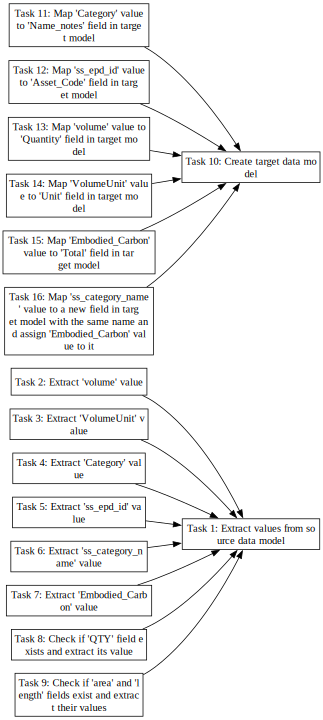

In [16]:
graph=display_graphviz('task4_graph.dot')
graph